In [13]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil


In [1018]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self):
        df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=14]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self):
        df, result_matrix = self.create_result_matrix()
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        df.drop('month_new_dealer', axis = 1 , inplace = True)
        result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix

In [1019]:
instance = DB_Data(host, database, user, password, sql_query)
pivot, result_matrix = instance.state_matrix()

In [945]:
pivot_sep = pivot.merge(sep_groupby, left_index = True, right_index = True , how = 'left')

In [946]:
pivot_sep = pivot_sep.fillna(0)

In [314]:
pivot_sep['month_new_dealer'] = pivot_sep.apply(instance.count_zeros_before_first_nonzero,axis =1)

In [430]:
pivot_12M_aug = pivot_sep[(pivot_sep['month_new_dealer']<=16)&(pivot_sep['2023-08']!=0)]
pivot_6M_aug = pivot_sep[(pivot_sep['month_new_dealer']<=22)&(pivot_sep['2023-08']!=0)]
pivot_3M_aug = pivot_sep[(pivot_sep['month_new_dealer']<=25)&(pivot_sep['2023-08']!=0)]
pivot_12M_jul = pivot_sep[(pivot_sep['month_new_dealer']<=15)&(pivot_sep['2023-07']!=0)]
pivot_6M_jul = pivot_sep[(pivot_sep['month_new_dealer']<=21)&(pivot_sep['2023-07']!=0)]
pivot_3M_jul = pivot_sep[(pivot_sep['month_new_dealer']<=24)&(pivot_sep['2023-07']!=0)]
pivot_12M_jun = pivot_sep[(pivot_sep['month_new_dealer']<=14)&(pivot_sep['2023-06']!=0)]
pivot_6M_jun = pivot_sep[(pivot_sep['month_new_dealer']<=20)&(pivot_sep['2023-06']!=0)]
pivot_3M_jun = pivot_sep[(pivot_sep['month_new_dealer']<=23)&(pivot_sep['2023-06']!=0)]
with pd.ExcelWriter('event_rate_dealers.xlsx', engine='openpyxl') as writer:

    # Write each DataFrame to a separate sheet
    pivot_12M_aug.to_excel(writer, sheet_name='12M_aug')
    pivot_6M_aug.to_excel(writer, sheet_name='6M_aug')
    pivot_3M_aug.to_excel(writer, sheet_name='3M_aug')
    pivot_12M_jul.to_excel(writer, sheet_name='12M_jul')
    pivot_6M_jul.to_excel(writer, sheet_name='6M_jul')
    pivot_3M_jul.to_excel(writer, sheet_name='3M_jul')
    pivot_12M_jun.to_excel(writer, sheet_name='12M_jun')
    pivot_6M_jun.to_excel(writer, sheet_name='6M_jun')
    pivot_3M_jun.to_excel(writer, sheet_name='3M_jun')

In [949]:
result_matrix.loc[result_matrix['2023-09'] > 0, 'actual'] = 0
result_matrix.loc[result_matrix['2023-09'] <= 0, 'actual'] = 1

In [950]:
result_1N = result_matrix[result_matrix['2023-08']=='Active_1N']
result_1N[result_1N['actual']==1].shape[0],result_1N.shape[0]

(462, 731)

In [951]:
result_2N = result_matrix[result_matrix['2023-08']=='Active_2N']
(result_2N[result_2N['actual']==1].shape[0]/ result_2N.shape[0])

0.8123791102514507

In [948]:
result_matrix['2023-09'] = pivot_sep['2023-09']

In [952]:
result_1N.shape[0]+result_2N.shape[0]

1248

In [939]:
result_matrix

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,actual
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,66.0,0.0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Inactive,Active,Active,Active,Active,12.0,0.0
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,0.0,1.0
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0.0,1.0
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active_1N,Active,Active_1N,Active,Active,Active,Active,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,18.0,0.0
7036499,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,70.0,0.0
7036501,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,15.0,0.0


result_matrix

In [976]:
result_1N = result_matrix[result_matrix['2023-07']=='Active_1N']
result_1N[result_1N['2023-08']=='Active_2N'].shape[0],result_1N.shape[0]

(517, 914)

In [978]:
result_2N = result_matrix[result_matrix['2023-07']=='Active_2N']
#(result_2N[result_2N['2023-08']==1].shape[0]/ result_2N.shape[0])

0.0

In [979]:
df = val_df_sep_aug[['actual','predicted','predict_proba']]
df = df.drop('predict_proba', axis = 1 )

In [980]:
result_1N['2023-09'] = result_1N['2023-09'].apply(lambda x: 0 if x > 0 else 1)

In [981]:
result_2N['2023-09'] = result_2N['2023-09'].apply(lambda x: 0 if x > 0 else 1)

In [982]:
df_1N = result_1N[['2023-07','2023-08']]
df_2N = result_2N[['2023-07','2023-08']]

In [983]:
df_1N['2023-08'] = df_1N['2023-08'].replace({'Active_2N':1 , 'Active':0})
df_2N['2023-08'] = df_2N['2023-08'].replace({'Active_3N':1 , 'Active':0})

In [985]:
df_1N = df_1N[['2023-08','2023-07']]
df_2N = df_2N[['2023-08','2023-07']]

In [986]:
df_1N['2023-07'] = 1
df_2N['2023-07'] = 1

In [987]:
df_1N.columns = df.columns
df_2N.columns = df.columns
df = pd.concat([df , df_1N, df_2N], axis = 0)

In [988]:
df

,actual,predicted
7000004,0.0,0
7000010,0.0,0
7000022,1.0,0
7000025,0.0,0
7000029,0.0,0
...,...,...
7040539,1.0,1
7040568,1.0,1
7040605,1.0,1
7040637,1.0,1


In [990]:
print('____________CONFUSION MATRIX SEPT______________')
print(confusion_matrix(val_df['actual'], val_df['predicted']))
print('\n')
print('____________CLASSIFICATION REPORT SEPT______________')
print(classification_report(val_df['actual'], val_df['predicted']))

____________CONFUSION MATRIX SEPT______________
[[4812 1512]
 [ 209  393]]


____________CLASSIFICATION REPORT SEPT______________
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85      6324
         1.0       0.21      0.65      0.31       602

    accuracy                           0.75      6926
   macro avg       0.58      0.71      0.58      6926
weighted avg       0.89      0.75      0.80      6926



In [475]:
420/517

0.8123791102514507

In [403]:
pivot_all = pivot_sep[(pivot_sep['month_new_dealer']<=28)&(pivot_sep['2023-08']!=0)]

In [404]:
pivot_all[pivot_all['2023-09']==0].shape[0]

1129

In [361]:
pivot_all.shape[0]

10058

In [422]:
pivot_6M = pivot_sep[(pivot_sep['month_new_dealer']>20)&(pivot_sep['2023-06']!=0)]

In [423]:
pivot_6M

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,month_new_dealer
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,25.00,0.00,0.0,0.00,26
7000205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,5.0,0.0,0.0,32.5,26.25,35.00,10.0,22.10,21
7000437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.5,9.0,51.0,50.5,51.0,35.00,41.75,58.0,71.00,21
7000901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,85.00,70.00,25.0,0.00,26
7001133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,18.00,18.00,10.0,20.00,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.00,132.00,150.6,111.00,26
7041151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.00,15.00,30.0,45.25,26
7041160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.00,36.00,24.0,12.00,26


In [363]:
pivot_6M[pivot_6M['2023-07']==0].shape[0]

548

In [364]:
pivot_6M.shape[0]

7908

In [424]:
pivot_3M = pivot_sep[(pivot_sep['month_new_dealer']>23)&(pivot_sep['2023-06']!=0)]
pivot_3M

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,month_new_dealer
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.00,26
7000901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,85.0,70.0,25.0,0.00,26
7001133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,18.0,18.0,10.0,20.00,25
7001143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,445.0,281.0,270.5,328.5,101.50,25
7001901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,63.0,30.0,103.0,31.00,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,132.0,150.6,111.00,26
7041151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.0,15.0,30.0,45.25,26
7041160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,36.0,24.0,12.00,26


In [415]:
with pd.ExcelWriter('event_rate_aug.xlsx', engine='openpyxl') as writer:

    # Write each DataFrame to a separate sheet
    pivot_12M.to_excel(writer, sheet_name='12M_aug')
    pivot_6M.to_excel(writer, sheet_name='6M_aug')
    pivot_3M.to_excel(writer, sheet_name='3M_aug')


In [420]:
with pd.ExcelWriter('event_rate_jul.xlsx', engine='openpyxl') as writer:

    # Write each DataFrame to a separate sheet
    pivot_12M.to_excel(writer, sheet_name='12M_jul')
    pivot_6M.to_excel(writer, sheet_name='6M_jul')
    pivot_3M.to_excel(writer, sheet_name='3M_jul')

In [425]:
with pd.ExcelWriter('event_rate_jun.xlsx', engine='openpyxl') as writer:

    # Write each DataFrame to a separate sheet
    pivot_12M.to_excel(writer, sheet_name='12M_jun')
    pivot_6M.to_excel(writer, sheet_name='6M_jun')
    pivot_3M.to_excel(writer, sheet_name='3M_jun')

In [366]:
pivot_3M.shape[0]

8780

In [341]:
pivot_3M[pivot_3M['2023-09']==0].shape[0]

973

In [331]:
(pivot_3M[pivot_3M['2023-09']==0].shape[0] - pivot_6M[pivot_6M['2023-09']==0].shape[0])/(pivot_3M.shape[0]-pivot_6M.shape[0])

0.17611336032388664

In [333]:
(pivot_all[pivot_all['2023-09']==0].shape[0] - pivot_6M[pivot_6M['2023-09']==0].shape[0])/(pivot_all.shape[0]-pivot_6M.shape[0])

0.17205422314911367

In [339]:
pivot_6M[pivot_6M['2023-09']==0].shape[0],pivot_all[pivot_all['2023-09']==0].shape[0]

(799, 1129)

In [307]:
pivot_sep[(pivot_sep['2023-08']!=0)&(pivot_sep['2023-09']==0)].to_csv('3m_inactive.csv')

In [302]:
pivot[pivot['2023-08']!=0]

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,122.5,75.0,90.0,155.0,46.0,111.0,96.00,80.0,80.0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,12.00,24.0,13.0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,21.0,24.0,0.0,29.0,0.0,27.0,12.00,12.0,24.0
7000025,98.0,108.5,87.0,105.0,107.5,102.0,107.0,117.0,60.0,85.0,...,108.8,73.0,167.0,137.0,173.0,158.0,132.0,109.00,147.0,121.0
7000029,85.0,50.0,129.0,120.0,90.0,85.0,85.0,80.0,60.0,90.0,...,88.0,113.0,60.0,88.0,185.0,30.0,60.0,55.00,90.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.00,82.5,56.0
7040758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,17.00,35.5,20.0
7040778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,50.00,50.0,100.5


In [306]:
174/988

0.17611336032388664

In [201]:
test = result_matrix[['2023-06', '2023-07', '2023-08']]
test['active'] = 1

In [202]:
test.shape

(16683, 4)

In [203]:
condition= ((test['2023-06']=='Active')|(test['2023-07']=='Active')|(test['2023-08']=='Active'))
test.loc[condition, 'active'] = 0

In [204]:
test[test['active']==0]

Month Year,2023-06,2023-07,2023-08,active
Sold To Party Code,,,,
7000004,Active,Active,Active,0
7000010,Active,Active,Active,0
7000022,Active,Active,Active,0
7000025,Active,Active,Active,0
7000029,Active,Active,Active,0
...,...,...,...,...
7041798,-,-,Active,0
7041810,-,-,Active,0
7041815,-,-,Active,0


In [205]:
11458-10210


1248

###### All dealers aug = 10210
###### 6m dealers aug = 8292
###### 3m dealers aug = 9280
###### last 3 months new dealers  = 988
###### last 6 months new dealers = 1918
###### last 12 months new dealers = 3175


In [1020]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
        result_matrix_2 = result_matrix_2[list(result_matrix_2.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        print(result_matrix_2.shape)
        print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','m+2'], index = result_matrix.index)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i , 28-value-4:28-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df

In [1021]:
pivot_prev = pd.read_csv('previous_year_data.csv')
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)
pivot_1 = pivot_prev.merge(pivot , left_index = True , right_index=True , how = 'right')
pivot_1 = pivot_1.fillna(0)
discount_df = pd.read_csv('data/discount_pivot.csv')
pd_df = pd.read_csv('data/pd_pivot.csv')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df.drop('Sold To Party Code', axis = 1 , inplace =True)
pd_df.drop('Sold To Party Code', axis = 1 , inplace =True)
discount_df['avg_discount'] = discount_df.mean(axis = 1)
pd_df['avg_pd'] = pd_df.mean(axis = 1)
pivot_2 = pivot_1.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
result_matrix_2 = result_matrix.drop([ '2023-06', '2023-07', '2023-08'],axis = 1)
instance_2 = Train()
test , y , result_1= instance_2.train_data(pivot_2,result_matrix)

(10216, 24)
(10216, 37)


In [1058]:
result_matrix_2.columns

Index(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05'],
      dtype='object', name='Month Year')

In [1022]:
train_df = instance_2.data(test , result_1)
train_df = instance_2.discount_pd(train_df , discount_df , pd_df)
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']
train_df = instance_2.district(train_df , distt_df, region_df)

In [1023]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree")
        self.save_model(model, "Decision_Tree") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf',class_weight={1:2.0})
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM")
        self.save_model(model, "SVM")

    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=61)
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest")
        self.save_model(model, "Random Forest")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors")
        self.save_model(model, "K-Nearest Neighbors")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost")
        self.save_model(model, "XGBoost")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest")
        self.save_model(model, "XGBoost Random Forest")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob

In [1024]:
train_df = train_df.fillna(0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(train_df)
y = y[y.index.isin(train_df.index)]
y_1 = y['state_m'].replace({'Active':0, 'Active_1N':1})

#y_1 = y_1['label']
trainer = Training_module(X, y_1)

In [1025]:
X.shape

(10216, 21)

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2354
           1       0.73      0.69      0.71      1018

    accuracy                           0.83      3372
   macro avg       0.80      0.79      0.79      3372
weighted avg       0.83      0.83      0.83      3372

Confusion Matrix for Random Forest:

[[2094  260]
 [ 316  702]]


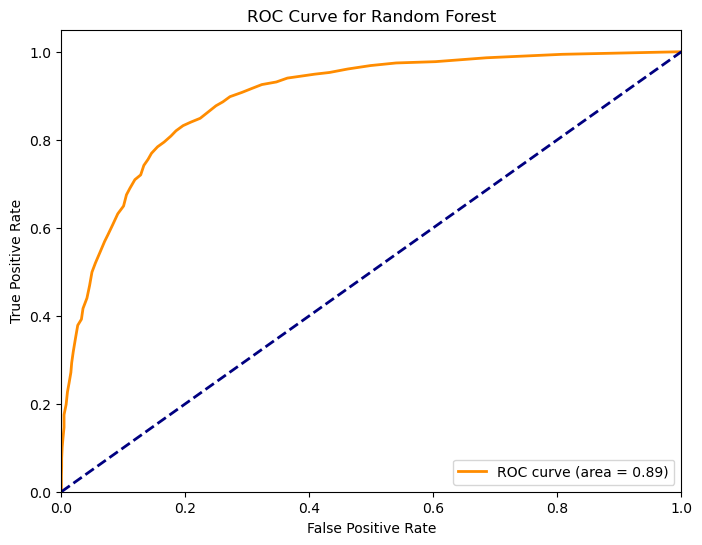

In [1026]:
trainer.train_random_forest()

In [832]:
[[2103  251]
 [ 318  700]]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3308339650.py, line 1)

### Sep Data 

In [1053]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["08'23"])==False]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix[result_matrix['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2022-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)

In [1037]:
#val_df = val_df.fillna(0)


Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.00,122.50,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.00,0.00,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.00,21.00,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.75,0.00,0.0,20.0,0.0,0.0,10.0,0.0,0.0,11.75
7036710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,58.00,61.5,58.0,64.0,27.0,28.0,25.0,31.0,219.00
7036715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,10.0,17.5,20.0,20.0,16.0,0.0,0.00


In [854]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')
val_df_1 = sc.fit_transform(val_df)

# Make predictions using the loaded model
predictions = loaded_model.predict(val_df_1)
pred_proba = loaded_model.predict_proba(val_df_1)[:,1]
val_df['predicted'] = predictions
val_df['predict_proba'] = pred_proba

In [855]:
result_matrix

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Active,Active,Active,Active
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active_1N,Active,Active_1N,Active,Active,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7036499,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7036501,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active


In [856]:
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']
pivot_2 = pivot.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')
pivot_2 = pivot_2.fillna(0)
pivot_2.loc[pivot_2['2023-09'] > 0, 'actual'] = 0
pivot_2.loc[pivot_2['2023-09'] <= 0, 'actual'] = 1

In [857]:
val_df = val_df.merge(pivot_2['actual'], left_index=True , right_index = True , how = 'inner')

In [809]:
#val_df[['predicted','actual']] = val_df[['predicted','actual']].replace({0:'Active',1:'Active_1N'})

In [858]:
print('CONFUSION MATRIX SEPTEMBER')
print(confusion_matrix(val_df['actual'],val_df['predicted']))
print('\n')
print('CLASSIFICATION REPORT SEPTEMBER')
print(classification_report(val_df['actual'],val_df['predicted']))

CONFUSION MATRIX SEPTEMBER
[[4812 1512]
 [ 209  393]]


CLASSIFICATION REPORT SEPTEMBER
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85      6324
         1.0       0.21      0.65      0.31       602

    accuracy                           0.75      6926
   macro avg       0.58      0.71      0.58      6926
weighted avg       0.89      0.75      0.80      6926



In [477]:
df = val_df[['actual','predicted','predict_proba']]
df = df.sort_values(by='predict_proba', ascending=False)

In [128]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df['predict_proba']:
    rank = percentile_rank_fun(df['predict_proba'], i)
    percentile_rank.append(rank)

In [129]:
df['percentile_rank'] = percentile_rank
df['decile_percentile_rank'] = pd.qcut(df['percentile_rank'], q=10, labels=False, duplicates='drop')

In [130]:
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df[df['decile_percentile_rank']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)25
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

160.0
136.0
119.0
111.0
39.0
26.0
14.0
8.0
3.0
1.0


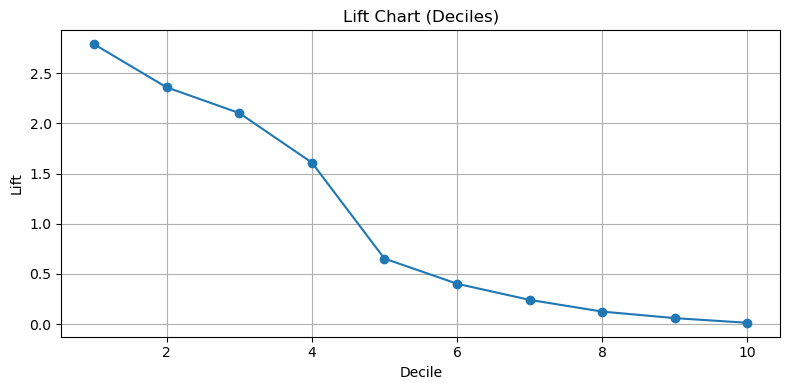

<Figure size 640x480 with 0 Axes>

In [131]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/(df[df['actual']==1].shape[0]/df.shape[0])
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles)')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')

In [133]:
print('Top 4 Deciles SEP')
for i in range(9,-1,-1):
    decile_data = df[df['decile_percentile_rank']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

Top 4 Deciles SEP
[[  0 494]
 [  0 160]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       494
         1.0       0.24      1.00      0.39       160

    accuracy                           0.24       654
   macro avg       0.12      0.50      0.20       654
weighted avg       0.06      0.24      0.10       654

[[  0 521]
 [  0 136]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       521
         1.0       0.21      1.00      0.34       136

    accuracy                           0.21       657
   macro avg       0.10      0.50      0.17       657
weighted avg       0.04      0.21      0.07       657

[[  0 526]
 [  0 119]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       526
         1.0       0.18      1.00      0.31       119

    accuracy                           0.18       645
   macro avg       0.09      0.50      0.

### SEP_AUG

In [1044]:
discount_24 = discount_24[discount_24['Month'].isin(["07'23"])==False]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_aug = result_matrix[result_matrix['2023-08']=='Active_1N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_aug = pivot[pivot.index.isin(result_aug.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_aug = pivot_aug[['2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_aug_1 = result_aug[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_aug.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_aug_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_aug= instance_2.data(pivot_aug, result_aug_1)
val_df_aug = instance_2.discount_pd(val_df_aug ,  discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df_aug = instance_2.district(val_df_aug , distt_df , region_df)

In [1045]:
val_df_aug['actual']=1

In [1046]:
val_df_sep = val_df.drop(['predicted','predict_proba'],axis = 1)

In [1051]:
val_df_sep

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,avg_sales,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,actual
7000004,80.00,96.0,111.0,58.0,61.0,-3.0,5.00,-26.5,91.0,34.00,...,63.000000,0.0,0.0,0.0,0.0,30874.620000,9972.625000,25,1,0.0
7000010,24.00,12.0,24.0,-9.8,12.0,7.0,24.00,12.0,24.0,24.00,...,12.450000,1.0,1.0,1.0,5.0,3024.923047,937.490000,51,1,0.0
7000022,12.00,12.0,27.0,0.0,9.0,23.5,-12.00,-9.0,22.0,12.00,...,9.104167,2.0,0.0,0.0,0.0,3236.875781,2083.333333,149,1,1.0
7000025,147.00,109.0,132.0,-28.0,-52.0,32.0,-20.00,36.0,23.2,-11.00,...,110.783333,0.0,0.0,0.0,0.0,60212.108125,19921.866667,237,1,0.0
7000029,90.00,55.0,60.0,60.0,-79.9,15.0,30.00,-58.0,-28.0,60.00,...,76.204167,0.0,0.0,0.0,0.0,29307.897500,12499.993333,141,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,20.00,5.0,15.0,-80.0,-139.0,-40.0,-72.00,-70.2,-71.8,-21.00,...,43.595833,0.0,0.0,0.0,0.0,7658.270469,6380.193333,209,1,0.0
7036499,154.00,170.5,235.0,31.0,-179.5,185.0,119.80,120.0,136.0,-33.00,...,86.362500,0.0,0.0,0.0,0.0,55596.635000,3375.000000,199,0,0.0
7036501,233.00,223.0,134.0,218.0,142.5,21.0,-772.50,121.0,-7.0,-129.50,...,171.312500,0.0,0.0,0.0,0.0,257812.995000,162944.110000,37,4,0.0
7036508,61.05,40.0,17.5,-17.4,-18.5,7.5,21.05,-26.0,-22.5,3.55,...,33.104167,0.0,0.0,0.0,0.0,9684.236250,6880.840000,239,1,1.0


In [1048]:
val_df_sep_aug = pd.concat([val_df_sep, val_df_aug], axis = 0)
val_df_sep_aug = val_df_sep_aug.fillna(0)

In [1052]:
X_val_sep_aug = val_df_sep_aug.drop('actual', axis = 1)
X_val_sep_aug_1 = sc.fit_transform(X_val_sep_aug)
loaded_model = joblib.load('Random Forest_model.pkl')
# Make predictions using the loaded model
predictions = loaded_model.predict(X_val_sep_aug_1)
pred_proba = loaded_model.predict_proba(X_val_sep_aug_1)[:,1]
val_df_sep_aug['predicted'] = predictions
val_df_sep_aug['predict_proba'] = pred_proba

ValueError: X has 23 features, but RandomForestClassifier is expecting 21 features as input.

In [1050]:
print('CONFUSION MATRIX SEPTEMBER-AUGUST')
print(confusion_matrix(val_df_sep_aug['actual'],val_df_sep_aug['predicted']))
print('\n')
print('CLASSIFICATION REPORT SEPTEMBER-AUGUST')
print(classification_report(val_df_sep_aug['actual'],val_df_sep_aug['predicted']))

CONFUSION MATRIX SEPTEMBER-AUGUST
[[5094 1230]
 [ 384  590]]


CLASSIFICATION REPORT SEPTEMBER-AUGUST
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      6324
         1.0       0.32      0.61      0.42       974

    accuracy                           0.78      7298
   macro avg       0.63      0.71      0.64      7298
weighted avg       0.85      0.78      0.80      7298



In [866]:

df = val_df_sep_aug[['actual','predicted','predict_proba']]
df = df.sort_values(by='predict_proba', ascending=False)
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df['predict_proba']:
    rank = percentile_rank_fun(df['predict_proba'], i)
    percentile_rank.append(rank)
percentile_rank
df['percentile_rank'] = percentile_rank
df['decile_percentile_rank'] = pd.qcut(df['percentile_rank'], q=10, labels=False, duplicates='drop')
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df[df['decile_percentile_rank']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

219.0
257.0
152.0
192.0
61.0
42.0
14.0
16.0
3.0
8.0


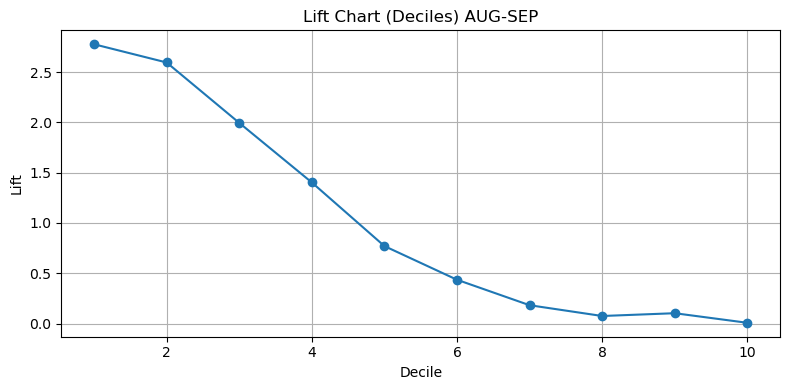

<Figure size 640x480 with 0 Axes>

In [584]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/(df[df['actual']==1].shape[0]/df.shape[0])
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles) AUG-SEP')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')

In [585]:
print('Top 4 Deciles SEP-AUG')
for i in range(9,-1,-1):
    decile_data = df[df['decile_percentile_rank']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

Top 4 Deciles SEP-AUG
[[  0 382]
 [  0 225]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       382
         1.0       0.37      1.00      0.54       225

    accuracy                           0.37       607
   macro avg       0.19      0.50      0.27       607
weighted avg       0.14      0.37      0.20       607

[[  0 464]
 [  0 246]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       464
         1.0       0.35      1.00      0.51       246

    accuracy                           0.35       710
   macro avg       0.17      0.50      0.26       710
weighted avg       0.12      0.35      0.18       710

[[  0 606]
 [  0 220]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       606
         1.0       0.27      1.00      0.42       220

    accuracy                           0.27       826
   macro avg       0.13      0.50    

In [1030]:
df = val_df_sep_aug[['actual','predicted']]
df['predicted_adjust'] = 0
#df['predicted_adjust'] = df['decile_percentile_rank'].apply(lambda x: 0 if x<8 else 1 )

In [1042]:
print(confusion_matrix(df['actual'], df['predicted']))
print(classification_report(df['actual'], df['predicted']))

[[5090 1234]
 [ 381  583]]
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      6324
         1.0       0.32      0.60      0.42       964

    accuracy                           0.78      7288
   macro avg       0.63      0.70      0.64      7288
weighted avg       0.85      0.78      0.80      7288



In [1031]:
df_top_2 = df[['actual','predicted_adjust']]
df_top_2.columns = ['actual', 'predicted']
df_top_2 = pd.concat([df_top_2 , df_1N, df_2N], axis = 0)

In [1032]:
print(confusion_matrix(df_top_2['actual'], df_top_2['predicted']))
print(classification_report(df_top_2['actual'], df_top_2['predicted']))

[[6324  501]
 [ 964  870]]
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      6825
         1.0       0.63      0.47      0.54      1834

    accuracy                           0.83      8659
   macro avg       0.75      0.70      0.72      8659
weighted avg       0.82      0.83      0.82      8659



In [1039]:
df['predicted_adjust'] = 0
df.iloc[:1250, df.columns.get_loc('predicted_adjust')] = 1


In [1040]:
df_top_2 = df[['actual','predicted_adjust']]
df_top_2.columns = ['actual', 'predicted']
df_top_2 = pd.concat([df_top_2 , df_1N, df_2N], axis = 0)
print(confusion_matrix(df_top_2['actual'], df_top_2['predicted']))
print(classification_report(df_top_2['actual'], df_top_2['predicted']))

[[5158 1667]
 [ 880  954]]
              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80      6825
         1.0       0.36      0.52      0.43      1834

    accuracy                           0.71      8659
   macro avg       0.61      0.64      0.62      8659
weighted avg       0.75      0.71      0.72      8659



In [894]:
val_df.shape[0]

6926

In [891]:
df_1N.shape[0]+df_2N.shape[0]

1371

In [650]:
df[df['predicted_adjust']==1]['decile_percentile_rank'].value_counts()

7    826
8    710
9    607
6      7
Name: decile_percentile_rank, dtype: int64

### AUG_JUL

In [764]:
jul_aug = pd.read_csv('val_aug_jul.csv')
jul_aug.index = jul_aug['Unnamed: 0']
jul_aug.drop('Unnamed: 0', axis = 1 , inplace = True)
X_jul_aug = jul_aug.drop('m', axis = 1)
X_jul_aug_1 = sc.fit_transform(X_jul_aug)

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_aug_1)
proba = loaded_model.predict_proba(X_jul_aug_1)[:,1]
jul_aug['predicted'] = predictions
jul_aug['pred_proba'] = proba
#jul_aug['m'] =jul_aug['m'].replace({'Active':0,'Active_1N':1})
# print('CONFUSION MATRIX JULY-AUGUST')
# print(confusion_matrix(jul_aug['m'],jul_aug['predicted']))
# print('\n')
# print('CLASSIFICATION REPORT JULY-AUGUST')
# print(classification_report(jul_aug['m'],jul_aug['predicted']))

In [89]:
df_1 =  jul_aug[['m','predicted','pred_proba']]
df_1 = df_1.sort_values(by='pred_proba', ascending=False)

In [90]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df_1['pred_proba']:
    rank = percentile_rank_fun(df_1['pred_proba'], i)
    percentile_rank.append(rank)
df_1['percentile_rank'] = percentile_rank


In [91]:
df_1['decile'] = pd.qcut(df_1['percentile_rank'], q=10, labels=False, duplicates='drop')

In [92]:
df_1.columns = df.columns

In [96]:
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df_1['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df_1[df_1['decile_percentile_rank']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

232
206
117
169
51
41
18
8
4
4


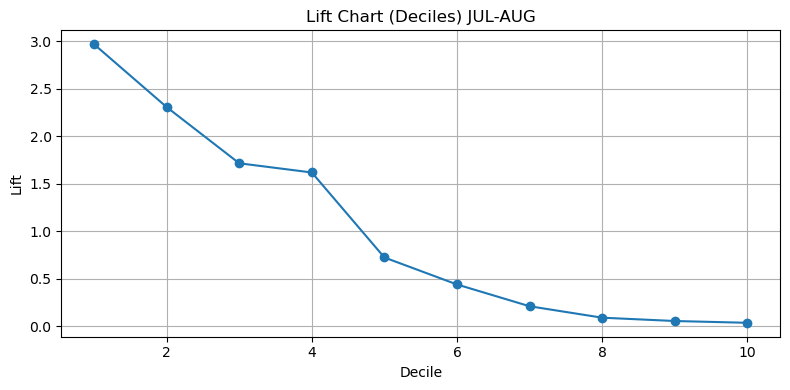

<Figure size 640x480 with 0 Axes>

In [97]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/(df_1[df_1['actual']==1].shape[0]/df_1.shape[0])
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles) JUL-AUG')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')

In [139]:
print('Top 4 Deciles AUG_JUL')
for i in range(9,-1,-1):
    decile_data = df_1[df_1['decile_percentile_rank']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

Top 4 Deciles AUG_JUL
[[  0 457]
 [  0 232]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       457
           1       0.34      1.00      0.50       232

    accuracy                           0.34       689
   macro avg       0.17      0.50      0.25       689
weighted avg       0.11      0.34      0.17       689

[[  0 581]
 [  0 206]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       581
           1       0.26      1.00      0.41       206

    accuracy                           0.26       787
   macro avg       0.13      0.50      0.21       787
weighted avg       0.07      0.26      0.11       787

[[  0 484]
 [  0 117]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.19      1.00      0.33       117

    accuracy                           0.19       601
   macro avg       0.10      0.50    

### JUL-AUG-SEP

In [98]:
#discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24_1 = discount_24[discount_24['Month']!= "08'23"]
discount_groupby_aug = discount_24_1.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby_aug = discount_groupby_aug.fillna(0)
discount_groupby_aug.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby_aug.index = discount_groupby_aug['sold_to_party_code']
discount_24_2 = discount_24_1[discount_24_1['Month']!= "07'23"]
discount_groupby_jul = discount_24_2.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby_jul = discount_groupby_jul.fillna(0)
discount_groupby_jul.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby_jul.index = discount_groupby_jul['sold_to_party_code']

In [99]:
result_jul = result_matrix[result_matrix['2023-08']=='Active_2N']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_jul = pivot[pivot.index.isin(result_jul.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_jul = pivot_jul[['2023-07','2021-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_jul_1 = result_jul[['2023-07','2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_jul.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_jul_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df_jul= instance_2.data(pivot_jul, result_jul_1)
val_df_jul = instance_2.discount_pd(val_df_jul , discount_groupby_jul[['avg_discount']], discount_groupby_jul[['avg_pd']])
val_df_jul = instance_2.district(val_df_jul , distt_df , region_df)

In [101]:
val_df_jul = val_df_jul.dropna()

In [103]:
val_df_jul['actual'] = 1

In [106]:
val_df_sep_aug_jul = pd.concat([val_df_sep_aug.drop(['predicted', 'predict_proba'], axis = 1), val_df_jul], axis = 0)

In [110]:
X_val_sep_aug_july = val_df_sep_aug_jul.drop('actual', axis = 1)
X_val_sep_aug_july_1 = sc.fit_transform(X_val_sep_aug_july)
predictions = loaded_model.predict(X_val_sep_aug_july_1)
proba = loaded_model.predict_proba(X_val_sep_aug_july_1)[:,1]
val_df_sep_aug_jul['predicted'] = predictions
val_df_sep_aug_jul['pred_proba'] = proba

print('CONFUSION MATRIX JULY-AUGUST-SEPTEMBER')
print(confusion_matrix(val_df_sep_aug_jul['actual'],val_df_sep_aug_jul['predicted']))
print('\n')
print('CLASSIFICATION REPORT JULY-AUGUST-SEPTEMBER')
print(classification_report(val_df_sep_aug_jul['actual'],val_df_sep_aug_jul['predicted']))

CONFUSION MATRIX JULY-AUGUST-SEPTEMBER
[[4837 1581]
 [ 306  916]]


CLASSIFICATION REPORT JULY-AUGUST-SEPTEMBER
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.84      6418
         1.0       0.37      0.75      0.49      1222

    accuracy                           0.75      7640
   macro avg       0.65      0.75      0.66      7640
weighted avg       0.85      0.75      0.78      7640



In [112]:
df_2 = val_df_sep_aug_jul[['actual','predicted','pred_proba']]
df_2 = df_2.sort_values(by='pred_proba', ascending=False)

In [114]:
def percentile_rank_fun(data, value):
    sorted_data = sorted(data)
    count_below = sum(1 for x in sorted_data if x < value)
    percentile_rank = (count_below / len(sorted_data)) * 100
    return percentile_rank
percentile_rank = []
for i in df_2['pred_proba']:
    rank = percentile_rank_fun(df_2['pred_proba'], i)
    percentile_rank.append(rank)
df_2['percentile_rank'] = percentile_rank

In [115]:
df_2['decile'] = pd.qcut(df_2['percentile_rank'], q=10, labels=False, duplicates='drop')

In [116]:
df_2.columns = df.columns

In [141]:
# Calculate cumulative gains and cumulative lift for each decile
cumulative_gains = []
cumulative_lift = []

total_positives = df_2['actual'].sum()
pos_act = []
pos_pred = []
for i in range(9,-1,-1):
    decile_data = df_2[df_2['decile_percentile_rank']==i]
    cumulative_positives = decile_data['actual'].sum()
    predicted_positives = decile_data['predicted'].sum()
    print(cumulative_positives)
    pos_act.append(cumulative_positives)
    pos_pred.append( predicted_positives)
    cumulative_gains.append(cumulative_positives / total_positives)
    cumulative_lift.append(cumulative_gains[-1] / (decile_data.shape[0] / total_positives))

268.0
342.0
214.0
191.0
94.0
60.0
26.0
14.0
9.0
4.0


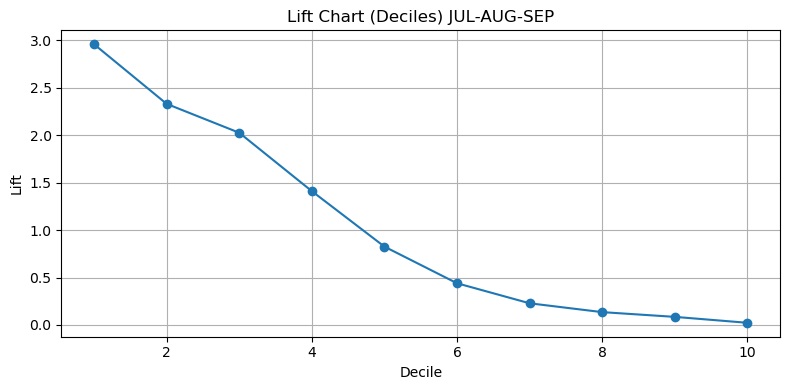

<Figure size 640x480 with 0 Axes>

In [142]:
for i in range(len(cumulative_lift)):
    cumulative_lift[i] = cumulative_lift[i]/(df_2[df_2['actual']==1].shape[0]/df_2.shape[0])
    
plt.figure(figsize=(8, 4))
plt.plot(range(1,  11), cumulative_lift, marker='o')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart (Deciles) JUL-AUG-SEP')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lift.png')

In [140]:
print('Top 4 Deciles SEP-AUG-JUL')
for i in range(9,-1,-1):
    decile_data = df_2[df_2['decile_percentile_rank']==i]
    print(confusion_matrix(decile_data['actual'],decile_data['predicted']))
    print(classification_report(decile_data['actual'],decile_data['predicted']))

Top 4 Deciles SEP-AUG-JUL
[[  0 298]
 [  0 268]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       298
         1.0       0.47      1.00      0.64       268

    accuracy                           0.47       566
   macro avg       0.24      0.50      0.32       566
weighted avg       0.22      0.47      0.30       566

[[  0 575]
 [  0 342]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       575
         1.0       0.37      1.00      0.54       342

    accuracy                           0.37       917
   macro avg       0.19      0.50      0.27       917
weighted avg       0.14      0.37      0.20       917

[[  0 446]
 [  0 214]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       446
         1.0       0.32      1.00      0.49       214

    accuracy                           0.32       660
   macro avg       0.16      0.50

In [148]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.00,122.50,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.00,0.00,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.00,21.00,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.75,0.00,0.0,20.0,0.0,0.0,10.0,0.0,0.0,11.75
7036710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,58.00,61.5,58.0,64.0,27.0,28.0,25.0,31.0,219.00
7036715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,10.0,17.5,20.0,20.0,16.0,0.0,0.00


In [164]:
train_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,m-3_qoq,avg_sales,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region
7000004,155.0,90.0,75.0,114.0,28.0,22.0,135.00,70.0,53.0,32.50,...,55.00,78.416667,0.0,0.0,0.0,0.0,45418.857333,11649.441979,27,1
7000010,12.0,33.8,0.0,-18.0,9.8,0.0,-13.00,9.8,-25.0,-5.00,...,0.00,26.450000,3.0,0.0,0.0,0.0,7740.108333,3348.170833,55,1
7000015,27.0,74.0,45.0,-50.0,3.5,-23.5,-48.50,47.0,-25.5,-27.50,...,-55.00,60.012500,0.0,0.0,0.0,0.0,26527.502527,8735.627813,256,1
7000022,29.0,0.0,24.0,29.0,0.0,24.0,5.00,-12.0,12.0,8.00,...,2.00,6.479167,1.0,0.0,0.0,0.0,2464.193442,768.258854,158,1
7000025,173.0,137.0,167.0,33.0,83.0,82.0,78.00,62.0,-8.0,100.00,...,119.00,105.991667,0.0,0.0,0.0,0.0,75982.741238,18881.577500,256,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036703,20.0,0.0,0.0,20.0,0.0,0.0,-36.25,-54.0,-30.0,4.25,...,-41.75,9.072917,2.0,1.0,0.0,0.0,3820.821825,1317.477500,352,1
7036710,64.0,58.0,61.5,64.0,58.0,61.5,64.00,58.0,61.5,6.00,...,31.50,12.562500,2.0,1.0,1.0,0.0,6411.474833,1332.979167,139,1
7036715,17.5,10.0,0.0,17.5,10.0,0.0,17.50,10.0,-20.0,17.50,...,0.00,2.395833,1.0,1.0,1.0,3.0,858.268775,501.332500,289,1
7036726,326.5,240.5,207.5,326.5,240.5,207.5,236.50,203.0,170.0,155.00,...,113.00,54.766667,0.0,0.0,0.0,0.0,34550.745833,6918.196667,26,1


In [167]:
columns = pd.DataFrame(train_df.columns, columns = ['Features'])

In [169]:
columns.to_csv('feature_list.csv')

In [172]:
columns

,Features
0,m-1
1,m-2
2,m-3
3,m-1_yoy
4,m-2_yoy
5,m-3_yoy
6,m-1_hy
7,m-2_hy
8,m-3_hy
9,m-1_qoq


In [256]:
pivot_sep = pivot.merge(sep_groupby , left_index=True , right_index=True , how = 'outer')

In [257]:
pivot_sep = pivot_sep.fillna(0)

In [258]:
pivot_sep['actual'] = 1

In [259]:
condition= (pivot_sep['2023-09']>0)
pivot_sep.loc[condition, 'actual'] = 0

In [260]:
pivot_sep[(pivot_sep['2023-08']>0)&(pivot_sep['2023-09']==0)]

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,actual
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.0,0.0,1
7000310,27.0,50.0,42.0,72.0,35.0,41.0,48.0,33.5,67.0,22.0,...,0.0,5.0,0.0,54.0,45.0,7.5,30.0,20.0,0.0,1
7000333,67.0,50.0,53.0,30.0,58.0,5.0,59.0,56.0,51.0,73.0,...,68.0,60.0,115.0,50.0,50.0,25.0,25.0,25.0,0.0,1
7000525,0.0,3.0,0.0,13.0,39.0,41.0,55.0,15.0,149.5,76.0,...,30.0,30.0,100.0,5.0,0.0,18.5,38.5,68.5,0.0,1
7000552,51.0,70.0,58.0,46.0,20.0,33.0,40.0,30.0,20.0,30.0,...,40.0,42.0,23.0,30.0,30.0,30.0,15.0,10.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.0,1
7041761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.5,0.0,1
7041762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1
7041773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1


In [262]:
result_matrix = result_matrix.merge(pivot_sep['actual'], left_index = True , right_index = True , how = 'outer')

In [263]:
result_matrix.rename(columns={'actual': '2023-09'}, inplace=True)

In [264]:
condition =  ((result_matrix['2023-08']=='Active') & (result_matrix['2023-09']==0.0))
result_matrix.loc[condition, '2023-09'] = 'Active'
condition =  ((result_matrix['2023-08']=='Active_1N') & (result_matrix['2023-09']==0.0))
result_matrix.loc[condition, '2023-09'] = 'Active' 
condition =  ((result_matrix['2023-08']=='Active_2N') & (result_matrix['2023-09']==0.0))
result_matrix.loc[condition, '2023-09'] = 'Active' 
condition =  ((result_matrix['2023-08']=='Active_3N') & (result_matrix['2023-09']==0.0))
result_matrix.loc[condition, '2023-09'] = 'Active'
condition =  ((result_matrix['2023-08']=='Inactive') & (result_matrix['2023-09']==0.0))
result_matrix.loc[condition, '2023-09'] = 'Active'
condition =  ((result_matrix['2023-08']=='Churn') & (result_matrix['2023-09']==0.0))
result_matrix.loc[condition, '2023-09'] = 'Active'
condition =  ((result_matrix['2023-08']=='Active_1N') & (result_matrix['2023-09']==1.0))
result_matrix.loc[condition, '2023-09'] = 'Active_2N'
condition =  ((result_matrix['2023-08']=='Active_2N') & (result_matrix['2023-09']==1.0))
result_matrix.loc[condition, '2023-09'] = 'Active_3N'
condition =  ((result_matrix['2023-08']=='Active_3N') &(result_matrix['2023-09']==1.0))
result_matrix.loc[condition, '2023-09'] = 'Inactive'
condition =  ((result_matrix['2023-08']=='Inactive') & (result_matrix['2023-09']==1.0))
result_matrix.loc[condition, '2023-09'] = 'Churn'

In [265]:
condition =  ((result_matrix['2023-08']=='Churn') & (result_matrix['2023-09']==1.0))
result_matrix.loc[condition, '2023-09'] = 'Churn'
condition =  ((result_matrix['2023-08']=='Active') & (result_matrix['2023-09']==1.0))
result_matrix.loc[condition, '2023-09'] = 'Active_1N'

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09
7013678,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
7034297,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1


In [272]:
pivot_sep[(pivot_sep['2023-08']>0)&(pivot_sep['2023-09']<=0)]

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,actual
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.0,0.0,1
7000310,27.0,50.0,42.0,72.0,35.0,41.0,48.0,33.5,67.0,22.0,...,0.0,5.0,0.0,54.0,45.0,7.5,30.0,20.0,0.0,1
7000333,67.0,50.0,53.0,30.0,58.0,5.0,59.0,56.0,51.0,73.0,...,68.0,60.0,115.0,50.0,50.0,25.0,25.0,25.0,0.0,1
7000525,0.0,3.0,0.0,13.0,39.0,41.0,55.0,15.0,149.5,76.0,...,30.0,30.0,100.0,5.0,0.0,18.5,38.5,68.5,0.0,1
7000552,51.0,70.0,58.0,46.0,20.0,33.0,40.0,30.0,20.0,30.0,...,40.0,42.0,23.0,30.0,30.0,30.0,15.0,10.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.0,1
7041761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.5,0.0,1
7041762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1
7041773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1


In [273]:
512/3175

0.16125984251968503

In [274]:
1129/10210

0.11057786483839373

In [376]:
importances = loaded_model.feature_importances_
feature_names = train_df.columns
indices = np.argsort(importances)[::-1]

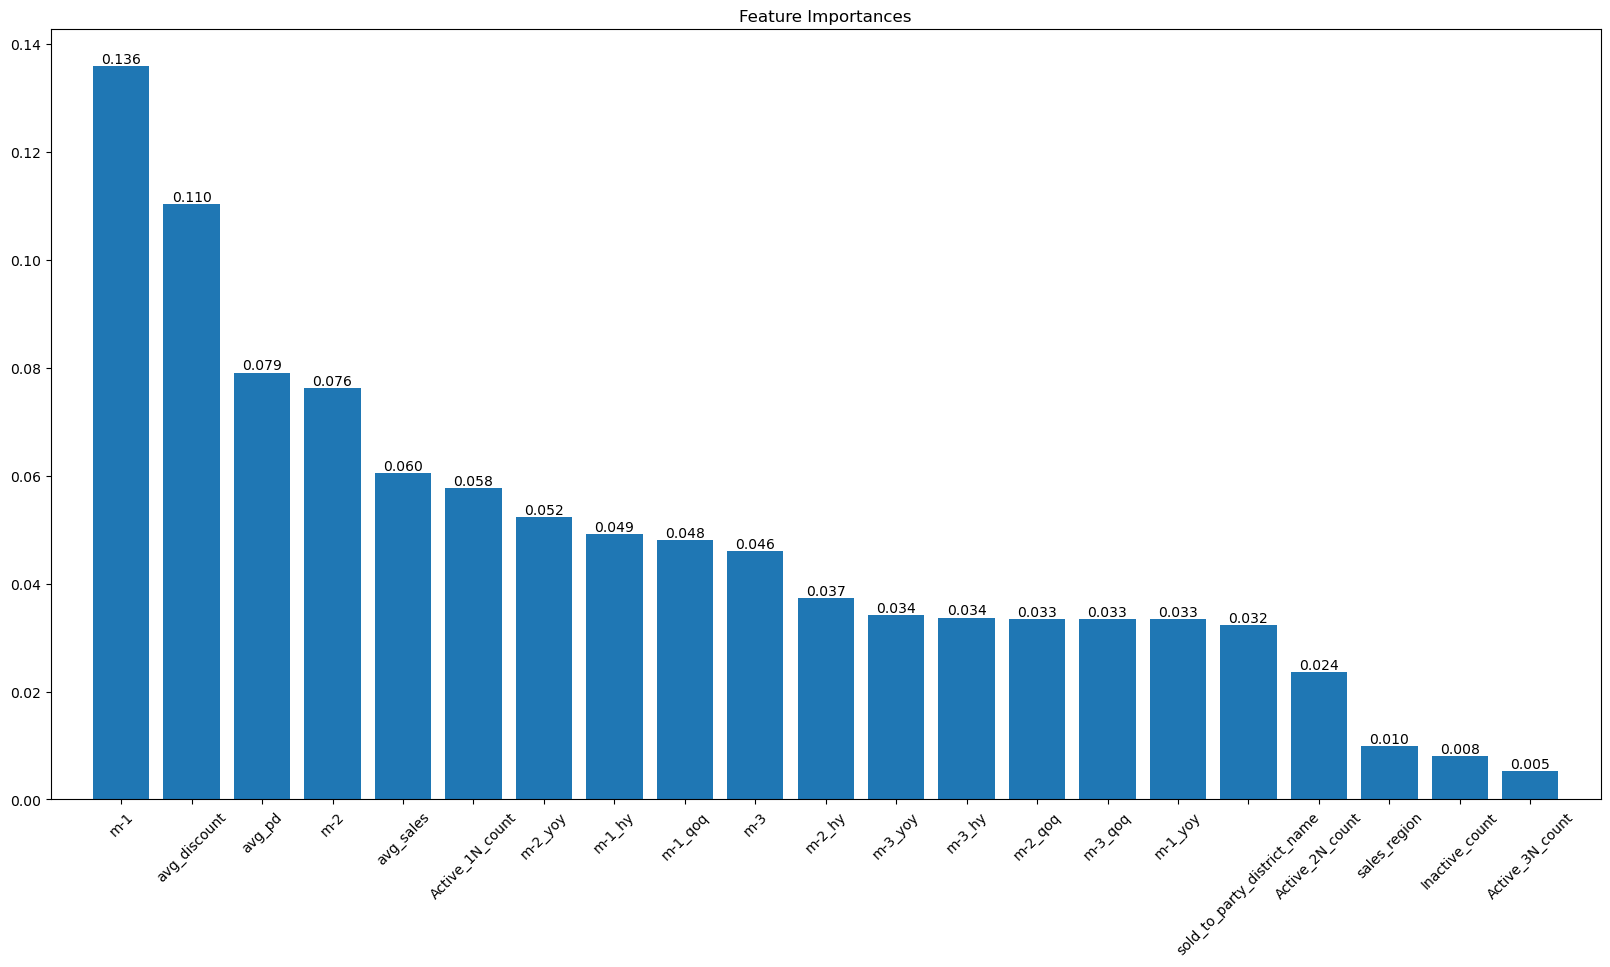

In [394]:
plt.figure(figsize=(20, 10))
plt.title("Feature Importances")
bars = plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])

# Add annotations for feature importance values on the bars
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{importance:.3f}", ha='center', va='bottom')

plt.show()


In [387]:
importances

0.9999999999999999

In [395]:
pivot_sep

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,month_new_dealer
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00,66.00,0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00,12.00,0
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00,0.00,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00,0.00,28
7041810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.65,31.35,28
7041815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,19.00,28


In [658]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
7041810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.65
7041815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00


In [659]:
pivot_5 = pivot.merge(distt_df['sold_to_party_district_name'], left_index=True , right_index = True , how = 'inner')

In [661]:
pivot_5['1st_6m'] = pivot_5[['2022-04','2022-05','2022-06','2022-07','2022-08','2022-09']].sum(axis =1)
pivot_5['2nd_6m'] = pivot_5[['2022-10','2022-11','2022-12','2023-01','2023-02','2023-03']].sum(axis =1)

In [673]:
distt_groupby = pivot_5.groupby('sold_to_party_district_name').agg({'1st_6m':['sum'],'2nd_6m':['sum']})

In [674]:
distt_groupby.columns = ['1st_6m','2nd_6m']
distt_groupby['distt_growth'] = (distt_groupby['2nd_6m']-distt_groupby['1st_6m'])/distt_groupby['1st_6m']

In [675]:
distt_groupby = distt_groupby.fillna(0)

In [676]:
pivot_5['growth_dealer'] = (pivot_5['2nd_6m']-pivot_5['1st_6m'])/pivot_5['1st_6m']

In [678]:
pivot_5 = pivot_5.fillna(0)
pivot_5 = pivot_5.replace({np.inf:0})

In [782]:
train_df_1 = train_df.drop(['sold_to_party_district_name', 'sales_region'], axis = 1)

In [783]:
train_df_1.index = train_df.index

In [784]:
train_df_1 = train_df_1.merge(distt_df['sold_to_party_district_name'], left_index=True, 
                             right_index=True , how = 'inner').merge(region_df['sales_region'], left_index=True , right_index=True, 
                                                                    how = 'inner')

In [785]:
distt_groupby['sold_to_party_district_name'] = distt_groupby.index

In [786]:
train_df_1 = train_df_1.merge(distt_groupby['distt_growth'], left_on='sold_to_party_district_name' , right_on='sold_to_party_district_name', how = 'inner')

In [787]:
train_df_1.index = train_df.index

In [788]:
train_df_1 = train_df_1.merge(pivot_5['growth_dealer'], left_index = True , right_index=True , how = 'inner')

In [789]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df_1['sold_to_party_district_name'] = le.fit_transform(train_df_1['sold_to_party_district_name'])
train_df_1['sales_region'] = le.fit_transform(train_df_1['sales_region'])

In [790]:
train_df_1.replace([np.inf, -np.inf], 0, inplace=True)

In [791]:
X = sc.fit_transform(train_df_1)
y_1 = y['state_m'].replace({'Active':0 , 'Active_1N':1})

In [792]:
trainer = Training_module(X, y_1)


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.80      0.96      0.88      2839
           1       0.86      0.51      0.64      1342

    accuracy                           0.81      4181
   macro avg       0.83      0.73      0.76      4181
weighted avg       0.82      0.81      0.80      4181

Confusion Matrix for Random Forest:

[[2724  115]
 [ 660  682]]


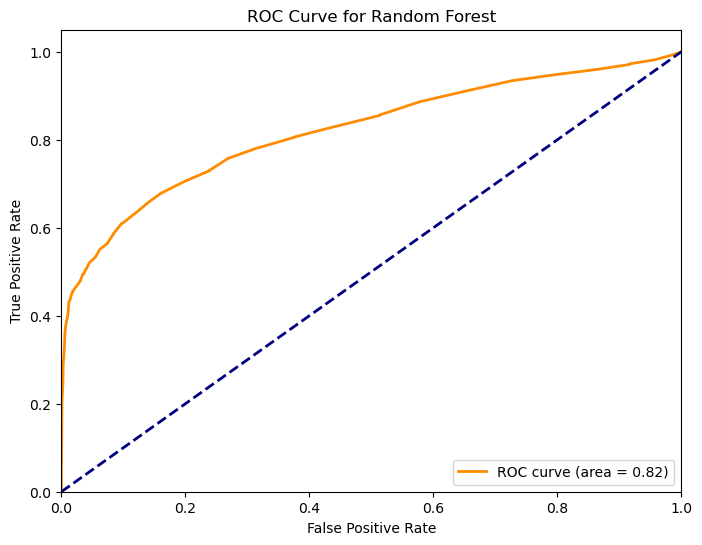

In [793]:
trainer.train_random_forest()

In [748]:
[[2103  251]
 [ 318  700]]

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,actual,predicted,predict_proba
7000004,80.00,80.0,96.00,60.00,58.0,61.00,-10.00,5.0,-26.50,-31.00,...,0.0,0.0,0.0,26859.696000,9972.625000,25,1,0.0,0,0.019608
7000010,13.00,24.0,12.00,1.00,-9.8,12.00,13.00,24.0,12.00,-11.00,...,1.0,1.0,5.0,2653.938437,937.490000,51,1,0.0,1,0.568627
7000022,24.00,12.0,12.00,12.00,0.0,9.00,24.00,-12.0,-9.00,-3.00,...,0.0,0.0,0.0,3309.500625,2083.333333,149,1,1.0,1,0.725490
7000025,121.00,147.0,109.00,46.00,-28.0,-52.00,-16.00,-20.0,36.00,-11.00,...,0.0,0.0,0.0,51799.686500,19921.866667,237,1,0.0,0,0.000000
7000029,90.00,90.0,55.00,30.00,60.0,-79.90,2.00,30.0,-58.00,30.00,...,0.0,0.0,0.0,26146.318000,12499.993333,141,1,0.0,0,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036644,69.60,27.9,78.90,44.60,2.9,78.90,32.10,-47.1,71.40,45.00,...,0.0,0.0,0.0,15728.585938,11394.733333,100,1,1.0,0,0.392157
7036659,3.50,8.8,23.25,-11.00,1.8,23.25,0.25,8.8,23.25,3.50,...,1.0,1.0,1.0,7077.220000,5476.580000,86,3,1.0,1,0.588235
7036668,36.30,55.0,30.00,11.30,30.0,30.00,11.30,30.0,-20.00,-13.70,...,0.0,0.0,0.0,14762.059844,6901.033333,25,1,1.0,0,0.431373
7036690,4.25,4.0,2.50,-7.75,-8.0,2.50,-7.75,-44.0,-21.50,4.25,...,0.0,0.0,0.0,0.000000,0.000000,112,4,1.0,1,0.588235


In [1029]:
print(confusion_matrix(val_df_sep_aug['actual'], val_df_sep_aug['predicted']))
print(classification_report(val_df_sep_aug['actual'], val_df_sep_aug['predicted']))

[[5090 1234]
 [ 381  583]]
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      6324
         1.0       0.32      0.60      0.42       964

    accuracy                           0.78      7288
   macro avg       0.63      0.70      0.64      7288
weighted avg       0.85      0.78      0.80      7288



In [ ]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
result_sep = result_matrix[result_matrix['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]
pivot_sep = pivot_sep[['2022-08','2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-08','2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
val_df = instance_2.data(pivot_sep, result_sep_1)
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)